In [222]:
import gc
gc.collect()

21140

In [224]:
import os, random, time
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import pytesseract
from transformers import BertModel, BertTokenizer

In [225]:
class FusionModel(nn.Module):
    def __init__(self, image_embedding_dim, text_embedding_dim, fusion_dim):
        super(FusionModel, self).__init__()
 
        # Image embedding module (using a pre-trained ResNet-50)
        self.image_embedding = nn.Sequential(*list(models.resnet50(pretrained=True).children())[:-1])
        self.image_fc = nn.Linear(2048, image_embedding_dim)
        
        # Text embedding module (using BERT)
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.text_fc = nn.Linear(768, text_embedding_dim)
        
        # Fusion layer
        self.fusion_fc = nn.Linear(image_embedding_dim + text_embedding_dim, fusion_dim)
        # Final dense layer
        self.final_fc = nn.Linear(fusion_dim, 128)  # You can adjust the output dimension as needed

    def forward(self, image, input_ids):
        # Image embedding
        image = self.image_embedding(image)
        image = image.view(image.size(0), -1)
        image = self.image_fc(image)
        
        # Text embedding
        text = self.bert_model(input_ids).last_hidden_state.mean(dim=1)  # Average pooling
        text = self.text_fc(text)
        
        # Fusion
        fusion = torch.cat((image, text), dim=1)
        fusion = self.fusion_fc(fusion)
        
        # Final dense layer
        output = self.final_fc(fusion)
        return output

In [226]:
from transformers import BertTokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

image_embedding_dim = 256
text_embedding_dim = 256
fusion_dim = 256
model = FusionModel(image_embedding_dim, text_embedding_dim, fusion_dim)

image_path = '/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/train/resume/0000030854.tif'
image = Image.open(image_path).convert('RGB')
text = pytesseract.image_to_string(image)  # Extract text using Tesseract
encoding = bert_tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
input_ids = encoding['input_ids']
print(input_ids.shape)
image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
image = image_transform(image).unsqueeze(0)
output = model(image, input_ids)
print(output)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 512])
tensor([[ 3.1039e-02,  6.4545e-02, -1.7777e-02,  2.0908e-02, -2.1281e-01,
          3.5274e-02,  2.5112e-01, -7.7692e-02, -8.4710e-03, -4.5244e-02,
         -1.0957e-01,  1.9548e-01, -3.9469e-02, -3.3004e-01,  1.0873e-01,
          1.0755e-01,  1.0325e-01, -3.2621e-02, -2.9277e-04,  1.2614e-02,
         -1.1076e-01,  8.6805e-03,  7.4148e-02, -9.6481e-03, -9.6331e-02,
         -1.8250e-02, -3.5125e-03,  6.7531e-02,  6.4568e-02,  1.7682e-01,
         -2.6009e-01, -8.3175e-02, -2.0995e-01,  6.9492e-02, -3.0994e-02,
          1.9172e-01,  6.5009e-02, -1.2645e-01,  2.3797e-02, -1.0099e-02,
          1.7696e-01, -6.1331e-02, -5.8230e-02, -9.6551e-02, -1.8827e-01,
         -9.8231e-02, -8.8320e-02,  2.7157e-03,  3.4342e-02,  3.3043e-02,
         -2.4942e-03,  8.0794e-02,  1.5089e-02,  8.6449e-02,  8.6741e-03,
          1.2951e-01,  2.8432e-02,  2.5602e-01, -6.6676e-02,  9.8969e-02,
         -5.0239e-02, -1.4286e-01,  2.2301e-02,  2.5605e-03,  8.7464e-02,
         -1.0348e

In [227]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BertTokenizer

class CustomDataset(Dataset):
    def __init__(self, image_folder, text_folder, transform=None):
        self.image_folder = image_folder
        self.text_folder = text_folder
        self.transform = transform
        self.image_paths = self._load_images()
        self.text_paths = self._load_text()
        self.max_text_length = 512  # Specify the maximum text length

        # Initialize the BERT tokenizer
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def _load_images(self):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        image_paths = []
        for root, _, files in os.walk(self.image_folder):
            for file in files:
                if file.lower().endswith(valid_extensions):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def _load_text(self):
        text_paths = []
        for image_path in self.image_paths:
            # Get the corresponding text file path
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            class_name = os.path.basename(os.path.dirname(image_path))
            text_path = os.path.join(self.text_folder, class_name, f"{base_name}.txt")
            if os.path.exists(text_path):
                text_paths.append(text_path)
            else:
                text_paths.append(None)  # None if the text file doesn't exist
        return text_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        text_path = self.text_paths[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if text_path is not None:
            with open(text_path, 'r', encoding='utf-8') as text_file:
                text = text_file.read()

            # Tokenize the text
            encoding = self.bert_tokenizer(text, return_tensors='pt', max_length=self.max_text_length, truncation=True, padding='max_length')
            input_ids = encoding['input_ids'].unsqueeze(0)
        else:
            # If there's no associated text file, create a tensor of zeros for padding
            input_ids = torch.zeros((self.max_text_length,), dtype=torch.long)

        return image, input_ids
    
batch_size = 1

train_image_folder = '/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/train'
train_text_folder = '/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/train_text'
train_dataset = CustomDataset(train_image_folder, train_text_folder, transform=image_transform)

test_image_folder = '/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/test'
test_text_folder = '/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/test_text'
test_dataset = CustomDataset(test_image_folder, test_text_folder, transform=image_transform)

print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train dataset length: 29
Test dataset length: 6


In [228]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

FusionModel(
  (image_embedding): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [229]:
for images, input_ids in test_loader:
    images = images.to(device)  # Move the image tensor to the device
    input_ids = input_ids.view(-1, input_ids.size(-1)).to(device)
    print(input_ids.shape)
    outputs = model(images, input_ids)  # Pass the reshaped input_ids
    print(outputs.shape)
    break

torch.Size([1, 512])
torch.Size([1, 128])


**TRIPLET TRAINING**

In [230]:
import os
import random
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class Triplet:
    def __init__(self, train_folder, train_text_folder, bert_tokenizer, max_text_length):
        self.train_folder = train_folder
        self.train_text_folder = train_text_folder
        self.labels = [label for label in os.listdir(train_folder) if label != '.ipynb_checkpoints']
        self.label_to_path = {label: os.path.join(train_folder, label) for label in self.labels}
        self.label_to_text_path = {label: os.path.join(train_text_folder, label) for label in self.labels}
        self.bert_tokenizer = bert_tokenizer
        self.max_text_length = max_text_length

    def get_triplet(self):
        anchor_label = random.choice(self.labels)
        anchor_path = random.choice(os.listdir(self.label_to_path[anchor_label]))
        anchor_text_path = os.path.join(self.label_to_text_path[anchor_label], anchor_path.split(".")[0] + ".txt")

        if os.path.exists(anchor_text_path):
            with open(anchor_text_path, 'r', encoding='utf-8') as text_file:
                text = text_file.read()

            # Tokenize the text
            encoding = self.bert_tokenizer(text, return_tensors='pt', max_length=self.max_text_length, truncation=True, padding='max_length')
            input_ids = encoding['input_ids'].squeeze(0)
        else:
            # If there's no associated text file, create a tensor of zeros for padding
            input_ids = torch.zeros((self.max_text_length,), dtype=torch.long)

        positive_label = anchor_label
        positive_path = random.choice(os.listdir(self.label_to_path[positive_label]))
        positive_text_path = os.path.join(self.label_to_text_path[positive_label], positive_path.split(".")[0] + ".txt")

        if os.path.exists(positive_text_path):
            with open(positive_text_path, 'r', encoding='utf-8') as text_file:
                text = text_file.read()

            # Tokenize the text
            encoding = self.bert_tokenizer(text, return_tensors='pt', max_length=self.max_text_length, truncation=True, padding='max_length')
            positive_input_ids = encoding['input_ids'].squeeze(0)
        else:
            # If there's no associated text file, create a tensor of zeros for padding
            positive_input_ids = torch.zeros((self.max_text_length,), dtype=torch.long)

        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        negative_path = random.choice(os.listdir(self.label_to_path[negative_label]))
        negative_text_path = os.path.join(self.label_to_text_path[negative_label], negative_path.split(".")[0] + ".txt")

        if os.path.exists(negative_text_path):
            with open(negative_text_path, 'r', encoding='utf-8') as text_file:
                text = text_file.read()

            # Tokenize the text
            encoding = self.bert_tokenizer(text, return_tensors='pt', max_length=self.max_text_length, truncation=True, padding='max_length')
            negative_input_ids = encoding['input_ids'].squeeze(0)
        else:
            # If there's no associated text file, create a tensor of zeros for padding
            negative_input_ids = torch.zeros((self.max_text_length,), dtype=torch.long)

        anchor_image = os.path.join(self.label_to_path[anchor_label], anchor_path)
        positive_image = os.path.join(self.label_to_path[positive_label], positive_path)
        negative_image = os.path.join(self.label_to_path[negative_label], negative_path)

        anchor_label_num = self.labels.index(anchor_label)
        positive_label_num = self.labels.index(positive_label)
        negative_label_num = self.labels.index(negative_label)

        return anchor_image, positive_image, negative_image, input_ids, positive_input_ids, negative_input_ids

class TripletDataset(Dataset):
    def __init__(self, train_folder, train_text_folder, bert_tokenizer, max_text_length, length, transform=None):
        self.triplet_generator = Triplet(train_folder, train_text_folder, bert_tokenizer, max_text_length)
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        anchor_image, positive_image, negative_image, anchor_text, positive_text, negative_text = self.triplet_generator.get_triplet()
        anchor = self._load_image(anchor_image)
        positive = self._load_image(positive_image)
        negative = self._load_image(negative_image)
        return anchor, positive, negative, anchor_text, positive_text, negative_text

    def _load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

bs = 1

train_folder = "/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/train"
test_folder = "/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/test"
train_text_folder = "/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/train_text"
test_text_folder = "/kaggle/input/panchathanthrakathaigal/panchathanthirakathaigal/test_text"

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = TripletDataset(train_folder, train_text_folder, bert_tokenizer, 512, length=9512, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = TripletDataset(test_folder, test_text_folder, bert_tokenizer, 512, length=2400, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

In [231]:
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

margin = 1
lr = 0.0001
n_epochs = 10
optimizer = Adam(model.parameters(), lr=lr)
loss_fn = TripletLoss(margin)

In [ ]:
def fit(model, num_epochs, train_loader,bs):
    for epoch in range(num_epochs):
        start = time.time()
        model.train()
        train_loss = 0.0
        for idx, i in enumerate(train_loader):
            aimg, pimg, nimg = i[0], i[1], i[2]
            atxt, ptxt, ntxt = i[3], i[4], i[5]
            aimg = aimg.to(device)
            pimg = pimg.to(device)
            nimg = nimg.to(device)
            aip_ids = atxt.view(-1, atxt.size(-1)).to(device)
            pip_ids = ptxt.view(-1, ptxt.size(-1)).to(device)
            nip_ids = ntxt.view(-1, ntxt.size(-1)).to(device)
            optimizer.zero_grad()
            a_op = model(aimg, aip_ids).requires_grad_(True)
            p_op = model(pimg, pip_ids).requires_grad_(True)
            n_op = model(nimg, nip_ids).requires_grad_(True)
            loss = loss_fn(a_op, p_op, n_op)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(f"({idx + 1}).  LOSS : {loss.item()}  SEEN : {bs * (idx + 1)}/{len(train_loader.dataset)}")
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, TIME: {time.time()-start}")

fit(model,n_epochs,train_loader,bs)

In [164]:
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 15.3 MB/s eta 0:00:0000:0100:01


In [173]:
import faiss
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import BertTokenizer

class CustomDataset(Dataset):
    def __init__(self, image_folder, text_folder, transform=None):
        self.image_folder = image_folder
        self.text_folder = text_folder
        self.transform = transform
        self.image_paths = self._load_images()
        self.text_paths = self._load_text()
        self.max_text_length = 512  # Specify the maximum text length

        # Initialize the BERT tokenizer
        self.bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    def _load_images(self):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        image_paths = []
        for root, _, files in os.walk(self.image_folder):
            for file in files:
                if file.lower().endswith(valid_extensions):
                    image_paths.append(os.path.join(root, file))
        return image_paths

    def _load_text(self):
        text_paths = []
        for image_path in self.image_paths:
            # Get the corresponding text file path
            base_name = os.path.splitext(os.path.basename(image_path))[0]
            class_name = os.path.basename(os.path.dirname(image_path))
            text_path = os.path.join(self.text_folder, class_name, f"{base_name}.txt")
            if os.path.exists(text_path):
                text_paths.append(text_path)
            else:
                text_paths.append(None)  # None if the text file doesn't exist
        return text_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        text_path = self.text_paths[idx]

        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        if text_path is not None:
            with open(text_path, 'r', encoding='utf-8') as text_file:
                text = text_file.read()

            # Tokenize the text
            encoding = self.bert_tokenizer(text, return_tensors='pt', max_length=self.max_text_length, truncation=True, padding='max_length')
            input_ids = encoding['input_ids'].unsqueeze(0)
        else:
            # If there's no associated text file, create a tensor of zeros for padding
            input_ids = torch.zeros((self.max_text_length,), dtype=torch.long)

        # Extract the class name from the image path
        class_name = os.path.basename(os.path.dirname(image_path))

        return image, input_ids, class_name  # Now, it also returns the class name
    
batch_size = 1

train_image_folder = '/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/train'
train_text_folder = '/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/train_text'
train_dataset = CustomDataset(train_image_folder, train_text_folder, transform=image_transform)

test_image_folder = '/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/test'
test_text_folder = '/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/test_text'
test_dataset = CustomDataset(test_image_folder, test_text_folder, transform=image_transform)

print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train dataset length: 9592
Test dataset length: 2400


In [176]:
for i in train_loader:
    print(i[2][0])
    break

resume


In [ ]:
train_embs = None
train_labels = []
for idx,i in enumerate(train_loader):
    if idx%100==0:
        print(idx)
    IMG, ID, L = i
    L = L[0]
    ID = ID.view(-1, ID.size(-1)).to(device)
    train_labels.append(L)
    emb = model(IMG.to(device), ID.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if train_embs is None:
        train_embs = emb
    else:
        train_embs = torch.cat((train_embs, emb), dim=0)

In [ ]:
test_embs = None
test_labels = []
for idx,i in enumerate(test_loader):
    if idx%100==0:
        print(idx)
    IMG, ID, L = i
    L = L[0]
    ID = ID.view(-1, ID.size(-1)).to(device)
    test_labels.append(L)
    emb = model(IMG.to(device), ID.to(device)) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if test_embs is None:
        test_embs = emb
    else:
        test_embs = torch.cat((test_embs, emb), dim=0)

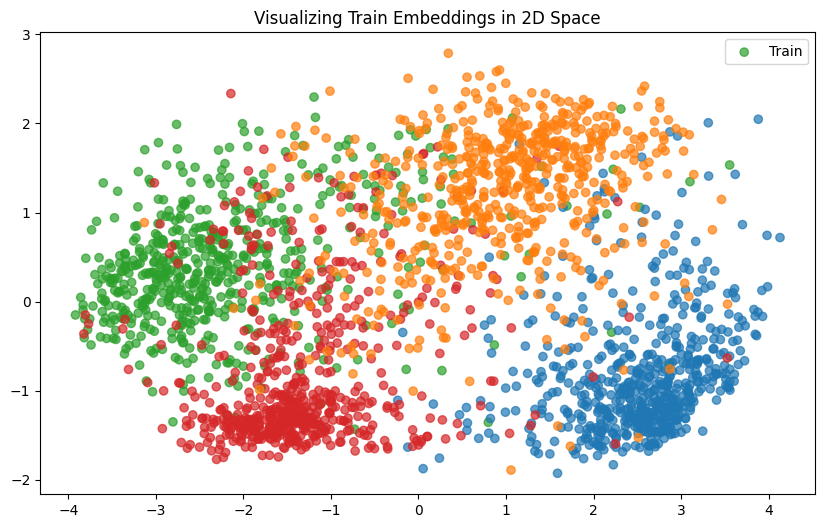

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_train_embeddings(train_embs, train_labels):
    label_to_int = {label: index for index, label in enumerate(set(train_labels))}
    train_labels_numeric = [label_to_int[label] for label in train_labels]

    pca = PCA(n_components=2)
    projected_embs = pca.fit_transform(train_embs)

    plt.figure(figsize=(10, 6))
    colormap = plt.get_cmap('tab10')
    colors = [colormap(label) for label in train_labels_numeric]b
    plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=colors, label='Train', alpha=0.7)
    plt.legend()
    plt.title('Visualizing Train Embeddings in 2D Space')
    plt.show()

# Assuming you have 'train_embs' and 'train_labels' defined
visualize_train_embeddings(test_embs.cpu(), test_labels)


In [197]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

def kmeans_clustering(train_embs, test_embs, labels1, labels2, num_clusters):
    all_embs = np.vstack((train_embs, test_embs))
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(all_embs)
    train_cluster_labels = cluster_labels[:len(train_embs)]
    test_cluster_labels = cluster_labels[len(train_embs):]
    
    label_mapping = {'invoice': 0, 'email': 1, 'file folder': 2, 'resume': 3}
    
    # Convert labels1 using the mapping
    labels1 = [label_mapping[label] for label in labels1]
    
    cluster_to_label = {}
    for cluster_id in range(num_clusters):
        cluster_samples = [labels1[i] for i, cluster_label in enumerate(train_cluster_labels) if cluster_label == cluster_id]
        label_counts = np.bincount(cluster_samples)
        cluster_to_label[cluster_id] = np.argmax(label_counts)
    
    predicted_labels = np.array([cluster_to_label[cluster_id] for cluster_id in test_cluster_labels])
    
    # Convert labels2 to the appropriate format (np.array) using the mapping
    labels2 = np.array([label_mapping[label] for label in labels2])
    
    acc = accuracy_score(labels2, predicted_labels)
    return acc

num_clusters = 4

# Assuming you have 'train_embs', 'test_embs', 'train_labels', and 'test_labels' defined
accuracy = kmeans_clustering(train_embs.cpu(), test_embs.cpu(), train_labels, test_labels, num_clusters)

print(f"Accuracy using k-means clustering: {accuracy * 100:.2f}%")


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy using k-means clustering: 84.92%


In [203]:
embs = train_embs.cpu().numpy()
index3 = faiss.IndexHNSWFlat(embs.shape[1], 128)  # M = 32 for the HNSW index
index3.add(embs)

In [207]:
import faiss

embs = train_embs.cpu().numpy()
index1 = faiss.IndexFlatL2(embs.shape[1])  # Assuming embs.shape[1] represents the dimensionality of the embeddings
embs_cpu_np = embs
index1.add(embs_cpu_np)

nlist = 100  # Number of cells/buckets
quantizer = faiss.IndexFlatL2(embs.shape[1])  # Quantizer index (same as IndexFlatL2)
index2 = faiss.IndexIVFFlat(quantizer, embs.shape[1], nlist)
index2.train(embs_cpu_np)
index2.add(embs_cpu_np)

index3 = faiss.IndexHNSWFlat(embs.shape[1], 128)  # M = 32 for the HNSW index
index3.add(embs_cpu_np)

nbits = 8  # Number of bits for the LSH hash
index4 = faiss.IndexLSH(embs.shape[1], nbits)
index4.add(embs_cpu_np)

In [209]:
def evaluatewithfaiss(embs,index):
    TOTAL = len(embs)
    CORRECT = 0
    start = time.time()
    for idx,emb in enumerate(embs):
        label = index.search(emb.reshape(1,-1),1)[1][0][0]
        if (train_labels[label][0] == test_labels[idx][0]):
            CORRECT += 1
    return f'{CORRECT}/{TOTAL}={(CORRECT/TOTAL)*100}',f'TIME = {time.time()-start} SECONDS'

embs2_cpu_np = test_embs.cpu().numpy()

print(f'IndexFlatL2 : {evaluatewithfaiss(embs2_cpu_np,index1)}')
print(f'IndexIVFFlat : {evaluatewithfaiss(embs2_cpu_np,index2)}')
print(f'IndexHNSWFlat : {evaluatewithfaiss(embs2_cpu_np,index3)}')
print(f'IndexLSH : {evaluatewithfaiss(embs2_cpu_np,index4)}')

IndexFlatL2 : ('1930/2400=80.41666666666667', 'TIME = 3.512096405029297 SECONDS')
IndexIVFFlat : ('1926/2400=80.25', 'TIME = 0.11482667922973633 SECONDS')
IndexHNSWFlat : ('1930/2400=80.41666666666667', 'TIME = 0.23928236961364746 SECONDS')
IndexLSH : ('1306/2400=54.41666666666667', 'TIME = 0.15253305435180664 SECONDS')


In [205]:
print(f'IndexHNSWFlat : {evaluatewithfaiss(embs2_cpu_np,index3)}')

IndexHNSWFlat : ('1930/2400=80.41666666666667', 'TIME = 0.26370906829833984 SECONDS')


**DOING WITH RESNET ALONE**

In [ ]:
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
from torch.optim import Adam,lr_scheduler
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.nn.parallel import DataParallel
import torchvision.models as models
from PIL import Image
import os
import pickle
import random
import time
import cv2

 

class Triplet:
    def __init__(self, train_folder):
        self.train_folder = train_folder
        self.labels = [label for label in os.listdir(train_folder) if label != '.ipynb_checkpoints']
        self.label_to_path = {label: os.path.join(train_folder, label) for label in self.labels}
    
    def get_triplet(self):
        anchor_label = random.choice(self.labels)
        anchor_path = random.choice(os.listdir(self.label_to_path[anchor_label]))
        positive_label = anchor_label
        positive_path = random.choice(os.listdir(self.label_to_path[positive_label]))
        negative_label = random.choice([label for label in self.labels if label != anchor_label])
        negative_path = random.choice(os.listdir(self.label_to_path[negative_label]))
        
        anchor_image = os.path.join(self.label_to_path[anchor_label], anchor_path)
        positive_image = os.path.join(self.label_to_path[positive_label], positive_path)
        negative_image = os.path.join(self.label_to_path[negative_label], negative_path)
        
        anchor_label_num = self.labels.index(anchor_label)
        positive_label_num = self.labels.index(positive_label)
        negative_label_num = self.labels.index(negative_label)
        
        return anchor_image, positive_image, negative_image

class TripletDataset(Dataset):
    def __init__(self, train_folder, length, transform=None,):
        self.triplet_generator = Triplet(train_folder)
        self.transform = transform
        self.length = length

    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        anchor = self._load_image(anchor_image)
        positive = self._load_image(positive_image)
        negative = self._load_image(negative_image)
        return anchor, positive, negative

    def _load_image(self, image_path):
        image = Image.open(image_path).convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image

    def get_triplet_names(self, index):
        anchor_image, positive_image, negative_image = self.triplet_generator.get_triplet()
        return anchor_image, positive_image, negative_image

bs = 4

train_folder = "/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/train"
test_folder = "/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/test"

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = TripletDataset(train_folder, 9600, transform=transform, )
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = TripletDataset(test_folder, 2400, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        resnet50 = models.resnet50(pretrained=True)
        self.convnet = nn.Sequential(*list(resnet50.children())[:-1])  # Remove the fully connected layer

    def forward(self, x):
        output = self.convnet(x)
        return output

    def get_embedding(self, x):
        return self.forward(x)

emb = EmbeddingNet()

class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2=None, x3=None):
        if x2 is None and x3 is None:
            return self.embedding_net(x1)
        return self.embedding_net(x1),self.embedding_net(x2),self.embedding_net(x3)

    def get_embedding(self, x):
        return self.embedding_net(x)

class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = torch.norm(anchor - positive, dim=1)
        distance_negative = torch.norm(anchor - negative, dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TripletNet(emb)
model = nn.DataParallel(model)
model = model.to(device)
margin = 1
lr = 0.0001
n_epochs = 10
optimizer = Adam(model.parameters(), lr=lr)
loss_fn = TripletLoss(margin)



In [ ]:
def fit(model, n_epochs, train_loader,bs):
    for epoch in range(n_epochs):
        start = time.time()
        model.train()
        train_loss = 0.0
        for idx, batch in enumerate(train_loader):
            anchor, positive, negative = batch
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            optimizer.zero_grad()
            anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
            anchor_embedding.requires_grad_(True)
            positive_embedding.requires_grad_(True)
            negative_embedding.requires_grad_(True)
            loss = loss_fn(anchor_embedding, positive_embedding, negative_embedding)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            print(f"({idx + 1}).  LOSS : {loss.item()}  SEEN : {bs * (idx + 1)}/{len(train_loader.dataset)}")
        print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss / len(train_loader):.4f}, TIME: {time.time()-start}")
        print('VALIDATION :')
        evaluate_model(model, valid_loader)
        print('TESTING :')
        evaluate_model(model, test_loader)

fit(model,n_epochs,train_loader,bs)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self._load_images()

    def _load_images(self):
        valid_extensions = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')
        for class_name in os.listdir(self.folder_path):
            class_folder = os.path.join(self.folder_path, class_name)
            if os.path.isdir(class_folder):
                for filename in os.listdir(class_folder):
                    if filename.lower().endswith(valid_extensions):
                        self.image_paths.append(os.path.join(class_folder, filename))
                        self.labels.append(class_name)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

    
train_folder = "/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/train"
test_folder = "/kaggle/input/docs-ocred/DOCS_WITH_OCR_EXTRACTED/test"

test_dataloader = DataLoader(CustomDataset(test_folder,transform=transform))
train_dataloader = DataLoader(CustomDataset(train_folder,transform=transform)) 

train_embs = None
train_labels = []
for idx,i in enumerate(train_dataloader):
    I, L = i
    print(idx)
    train_labels.append(L)
    emb = model(I) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if train_embs is None:
        train_embs = emb
    else:
        train_embs = torch.cat((train_embs, emb), dim=0)

test_embs = None
test_labels = []
for idx,i in enumerate(test_dataloader):
    I, L = i
    print(idx)
    test_labels.append(L)
    emb = model(I) # Assuming `model_loaded(I)` returns a PyTorch tensor
    emb = emb.detach()
    if test_embs is None:
        test_embs = emb
    else:
        test_embs = torch.cat((test_embs, emb), dim=0)

In [216]:
train_embs.shape

torch.Size([9592, 2048, 1, 1])

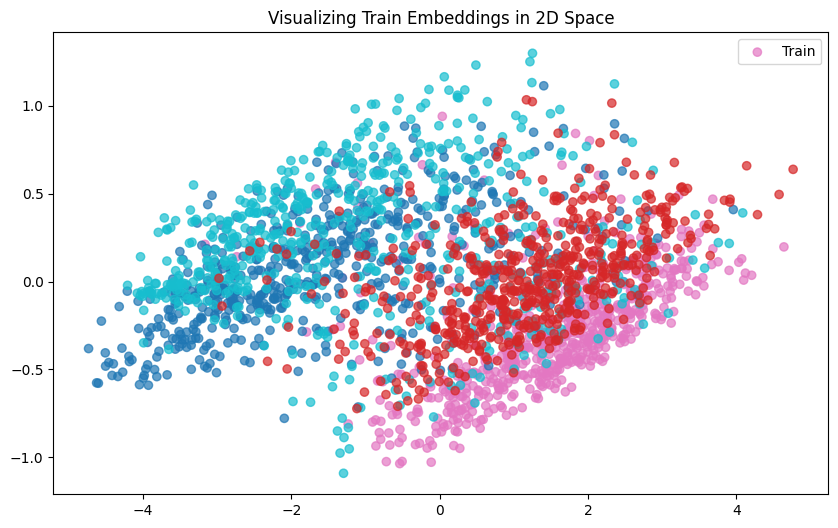

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_train_embeddings(train_embs, train_labels):
    # Flatten the spatial dimensions
    train_embs_flat = train_embs.view(train_embs.size(0), -1).cpu().numpy()

    pca = PCA(n_components=2)
    projected_embs = pca.fit_transform(train_embs_flat)

    plt.figure(figsize=(10, 6))
    colormap = plt.get_cmap('tab10')
    
    # Flatten nested tuples if present in train_labels
    train_labels_flat = [label[0] if isinstance(label, tuple) else label for label in train_labels]
    
    # Convert labels to integer values
    label_to_int = {label: index for index, label in enumerate(set(train_labels_flat))}
    train_labels_numeric = [label_to_int[label] for label in train_labels_flat]
    
    plt.scatter(projected_embs[:, 0], projected_embs[:, 1], c=train_labels_numeric, cmap=colormap, label='Train', alpha=0.7)
    plt.legend()
    plt.title('Visualizing Train Embeddings in 2D Space')
    plt.show()

# Assuming you have 'train_embs' and 'train_labels' defined
visualize_train_embeddings(test_embs, test_labels)


In [221]:
import faiss

embs_cpu_np = train_embs.cpu().numpy()
embs_cpu_np = embs_cpu_np.reshape(embs_cpu_np.shape[0], -1)

index1 = faiss.IndexFlatL2(embs_cpu_np.shape[1])  # Assuming embs_cpu_np.shape[1] represents the dimensionality of the embeddings
index1.add(embs_cpu_np)

nlist = 100  # Number of cells/buckets

quantizer = faiss.IndexFlatL2(embs_cpu_np.shape[1])  # Quantizer index (same as IndexFlatL2)
index2 = faiss.IndexIVFFlat(quantizer, embs_cpu_np.shape[1], nlist)
index2.train(embs_cpu_np)
index2.add(embs_cpu_np)

index3 = faiss.IndexHNSWFlat(embs_cpu_np.shape[1], 128)  # M = 32 for the HNSW index
index3.add(embs_cpu_np)

nbits = 8  # Number of bits for the LSH hash
index4 = faiss.IndexLSH(embs_cpu_np.shape[1], nbits)
index4.add(embs_cpu_np)

def evaluatewithfaiss(embs,index):
    TOTAL = len(embs)
    CORRECT = 0
    start = time.time()
    for idx,emb in enumerate(embs):
        label = index.search(emb.reshape(1,-1),1)[1][0][0]
        if train_labels[label][0]==test_labels[idx][0]:
            CORRECT += 1
    return f'{CORRECT}/{TOTAL}={(CORRECT/TOTAL)*100}',f'TIME = {time.time()-start} SECONDS'

embs2_cpu_np = test_embs.cpu().numpy()
embs2_cpu_np = embs2_cpu_np.reshape(embs2_cpu_np.shape[0], -1)

print(f'IndexIVFFlat : {evaluatewithfaiss(embs2_cpu_np,index2)}')
print(f'IndexHNSWFlat : {evaluatewithfaiss(embs2_cpu_np,index3)}')
print(f'IndexLSH : {evaluatewithfaiss(embs2_cpu_np,index4)}')
#print(f'IndexFlatL2 : {evaluatewithfaiss(embs2_cpu_np,index1)}')

IndexIVFFlat : ('1971/2400=82.125', 'TIME = 1.386824131011963 SECONDS')
IndexHNSWFlat : ('2008/2400=83.66666666666667', 'TIME = 4.808790445327759 SECONDS')
IndexLSH : ('601/2400=25.041666666666668', 'TIME = 0.16791677474975586 SECONDS')
